### paper plots

pretty plots for final paper

In [1]:
import autoencodeSVJ.utils as utils
import autoencodeSVJ.evaluate as ev
import glob
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
matplotlib.rcParams.update({'font.size': 16})
from collections import OrderedDict as odict
import pandas as pd
import glob
import os
import tensorflow as tf

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Using TensorFlow backend.


In [2]:
top = utils.summary().cfilter(['*auc*', 'target_dim', 'filename', 'signal_path', 'batch*', 'learning_rate']).sort_values('mae_auc')[::-1]
top.head(10)

,batch_size,filename,learning_rate,mae_auc,mse_auc,signal_path,target_dim
96,32,hlf_eflow3_7_v159,0.00146312,0.902315,0.900523,data/all_signals/3000GeV_0.30/base_3/*.h5,7
179,32,hlf_eflow3_7_v38,0.000910648,0.897851,0.891363,data/all_signals/3000GeV_0.30/base_3/*.h5,7
255,64,hlf_eflow3_9_v10,0.0005,0.894303,0.89324,data/all_signals/1500GeV_0.15/base_3/*.h5,9
23,64,hlf_eflow3_6_v3,0.0005,0.890441,0.889744,data/all_signals/2000GeV_0.30/base_3/*.h5,6
136,32,hlf_eflow3_7_v195,0.000838053,0.884811,0.884847,data/all_signals/3000GeV_0.30/base_3/*.h5,7
87,32,hlf_eflow3_7_v150,0.003303,0.882353,0.88152,data/all_signals/3000GeV_0.30/base_3/*.h5,7
139,32,hlf_eflow3_7_v198,0.00251508,0.881822,0.880606,data/all_signals/3000GeV_0.30/base_3/*.h5,7
86,32,hlf_eflow3_7_v15,0.000251868,0.881179,0.88605,data/all_signals/3000GeV_0.30/base_3/*.h5,7
44,32,hlf_eflow3_7_v111,0.000249307,0.880655,0.876243,data/all_signals/3000GeV_0.30/base_3/*.h5,7
53,32,hlf_eflow3_7_v12,0.000662266,0.880288,0.88518,data/all_signals/3000GeV_0.30/base_3/*.h5,7


In [100]:
l = {}
for f in glob.glob('TEST/*'):
    lp = pd.read_csv(f)
    fp = f.split('/')[-1]
    lp['name'] = fp
    l[fp] = lp
l = pd.concat(l)

l['mass_nu_ratio'] = zip(l.mass, l.nu)
# l = l.drop(['Unnamed: 0', 'mass', 'nu'], axis=1).T
l0 = l.pivot('mass_nu_ratio', 'name', 'auc')

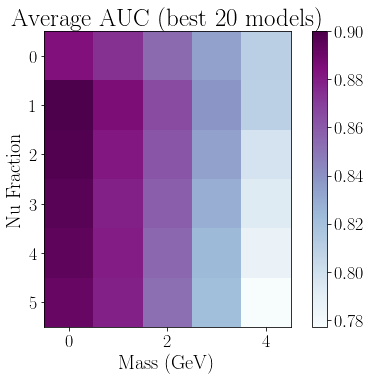

In [101]:
n = 20
lp = l0.iloc[:,np.argsort(l0.mean()).values[::-1][:n]].mean(axis=1).to_frame().reset_index().rename(columns={0: 'auc'})
lp['mass'] = lp.mass_nu_ratio.apply(lambda x: x[0])
lp['nu'] = lp.mass_nu_ratio.apply(lambda x: x[1])
plt.figure(figsize=(6.9,6))
lp = lp.drop('mass_nu_ratio', axis=1).pivot('mass','nu', 'auc')
plt.imshow(lp, vmax=.9, cmap='BuPu')
plt.colorbar()
plt.title('Average AUC (best {} models)'.format(n), fontsize=25)
plt.xlabel('Mass (GeV)', fontsize=20)
plt.ylabel('Nu Fraction', fontsize=20)
plt.show()

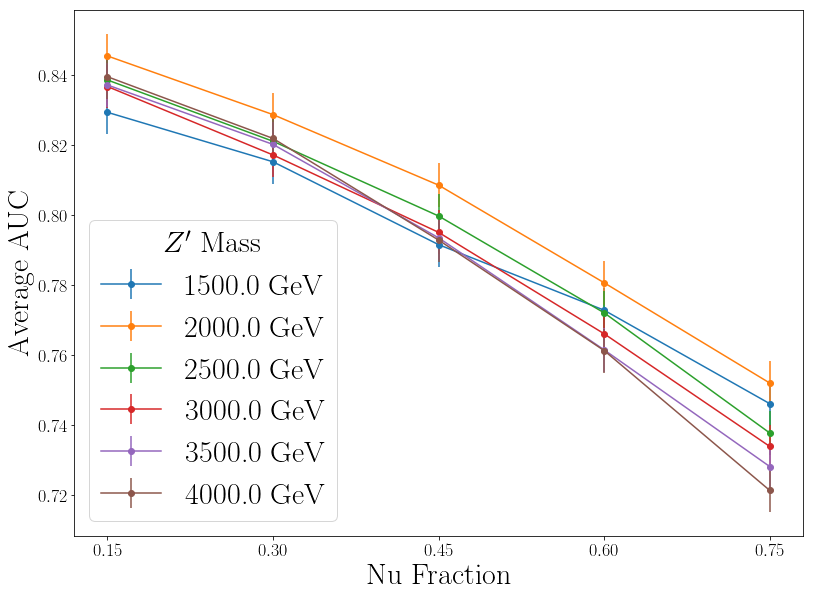

In [102]:
c = l0.iloc[:,:10]
# c = 5
means = c.mean(axis=1)
masses, nus = np.asarray(map(np.asarray, means.index)).T
aucs = means.values

plt.figure(figsize=(12,9))
for mass in sorted(set(masses)):
    plt.errorbar(nus[masses == mass], aucs[masses == mass], marker='o', yerr=np.std(c.std(axis=1)), label='{} GeV'.format(mass))
plt.xlabel('Nu Fraction')
plt.ylabel('Average AUC')
plt.xticks(np.unique(nus))
plt.legend(title=r'$Z^{\prime}$ Mass')
plt.show()

# important
`data_holder` basically loads all signal data into memory at once, while `auc_getter` gets and generates errors, reconstructed data, and normalized data on a gievn training run. Both of these things are critical to the later plotting

In [104]:
eflow_base = 3

dholder = ev.data_holder(
    qcd='data/background/base_3/*.h5',
    **{os.path.basename(p): '{}/base_{}/*.h5'.format(p, eflow_base) for p in glob.glob('data/all_signals/*')}
)
dholder.load()
dists = {v.name: v for v in dholder.get('data')}
signal = utils.data_table(pd.concat([v.df for v in dists.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average)')
qcd = dists['qcd']

found 31 datasets


In [115]:
tf.reset_default_graph()
agetter = ev.auc_getter('hlf_eflow3_7_v159', times=True)
norm, errors, recon = agetter.get_errs_recon(dholder)
aucs = agetter.get_aucs(errors)
fmt = agetter.auc_metric(aucs)
signal_recon = utils.data_table(pd.concat([v.df for v in recon.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average) pred')
signal_norm = utils.data_table(pd.concat([v.df for v in norm.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average)')
signal_err = utils.data_table(pd.concat([v.df for v in errors.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average)')

found 1 matches with search '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/hlf_eflow3_7_v159.summary'
:: TIME: init executed in 1.28 s
:: TIME: test dataset executed in 0.09 s
train_shell :: using saved model
:: TIME: recon gen executed in 17.99 s
:: TIME: auc grab executed in 0.63 s


In [106]:
styles = {
    'Z': {
        'facecolor': 'm',
        'histtype': 'step',
        'fill': True,
        'edgecolor': 'k',
        'label': r'SVJ',
        'alpha': 0.4,
#         'hatch': '/'
    },
    'qcd': {
        'facecolor': 'y',
        'histtype': 'step',
        'fill': True,
        'edgecolor': 'k',
        'label': r'QCD',
        'alpha': 0.4

    },
    'ttbar': {
        'facecolor': 'C0',
        'label': r'$t\bar{t}$',
        'edgecolor': 'w',
        'hatch': '//',
        'fill': True,
        'histtype': 'step',
        'alpha': 0.4

    }
}

order = [
    'ttbar',
    'Z',
    'qcd'
]


var_styles = {
    'ChargedFraction': {
        'xlabel': r'Charged Fraction',
        'fontsize': 20,
    },
    'Pt': {
        'xlabel': r'$\displaystyle p_{T}$',
        'fontsize': 20,
        'range': (0., 2000.),
    },
    'Eta': {
        'xlabel': r'$\displaystyle \eta$',
        'fontsize': 20,
#         'range': (0., 0.7),
    },
    'Phi': {
        'xlabel': r'$\displaystyle \phi$',
        'fontsize': 20,
#         'range': (0., 0.7),
    },
    'M': {
        'xlabel': 'Mass',
        'fontsize': 20,
        'range': (0., 500.)
    },
    'mae': {
        'xlabel': 'Reconstruction Error (MAE)',
        'fontsize': 30,
    },
    'PTD': {
        'xlabel': 'PTD',
        'fontsize': 20,
    },
    'Axis2': {
        'xlabel': 'Axis_2',
        'fontsize': 20,
        'range': (0, 0.2)
    }
}

# more than needed
for i in range(100):
    var_styles['eflow {}'.format(i)] = {}
    var_styles['eflow {}'.format(i)]['xlabel'] = "Variable {}".format(i)
    var_styles['eflow {}'.format(i)]['fontsize'] = 20

eflow_ranges = {
    1: (0,0.6),
    2: (0,0.5),
    3: (0,0.4),
    4: (0,0.4),
    5: (0,0.25),
    6: (0,0.15),
    7: (0,0.2),
    8: (0,0.15),
    9: (0,0.3),
    10: (0,0.2),
    11: (0,0.15),
    12: (0,0.15)
}

for num,rng in eflow_ranges.items():
    var_styles['eflow {}'.format(num)]['range'] = rng

### Pre-use histograms

Thing to convert data into column-based shit:

In [107]:
from collections import OrderedDict

def converter(toplot): 
    colsets = [tuple(x.columns) for x in toplot.values()]
    assert(len(set(colsets)) == 1)
    var = colsets[0]

    names = sorted(toplot.keys())

    out = OrderedDict()
    for name in names:
        for v in var:
            if v not in out:
                out[v] = OrderedDict()
            out[v][name] = toplot[name][v]

    return out

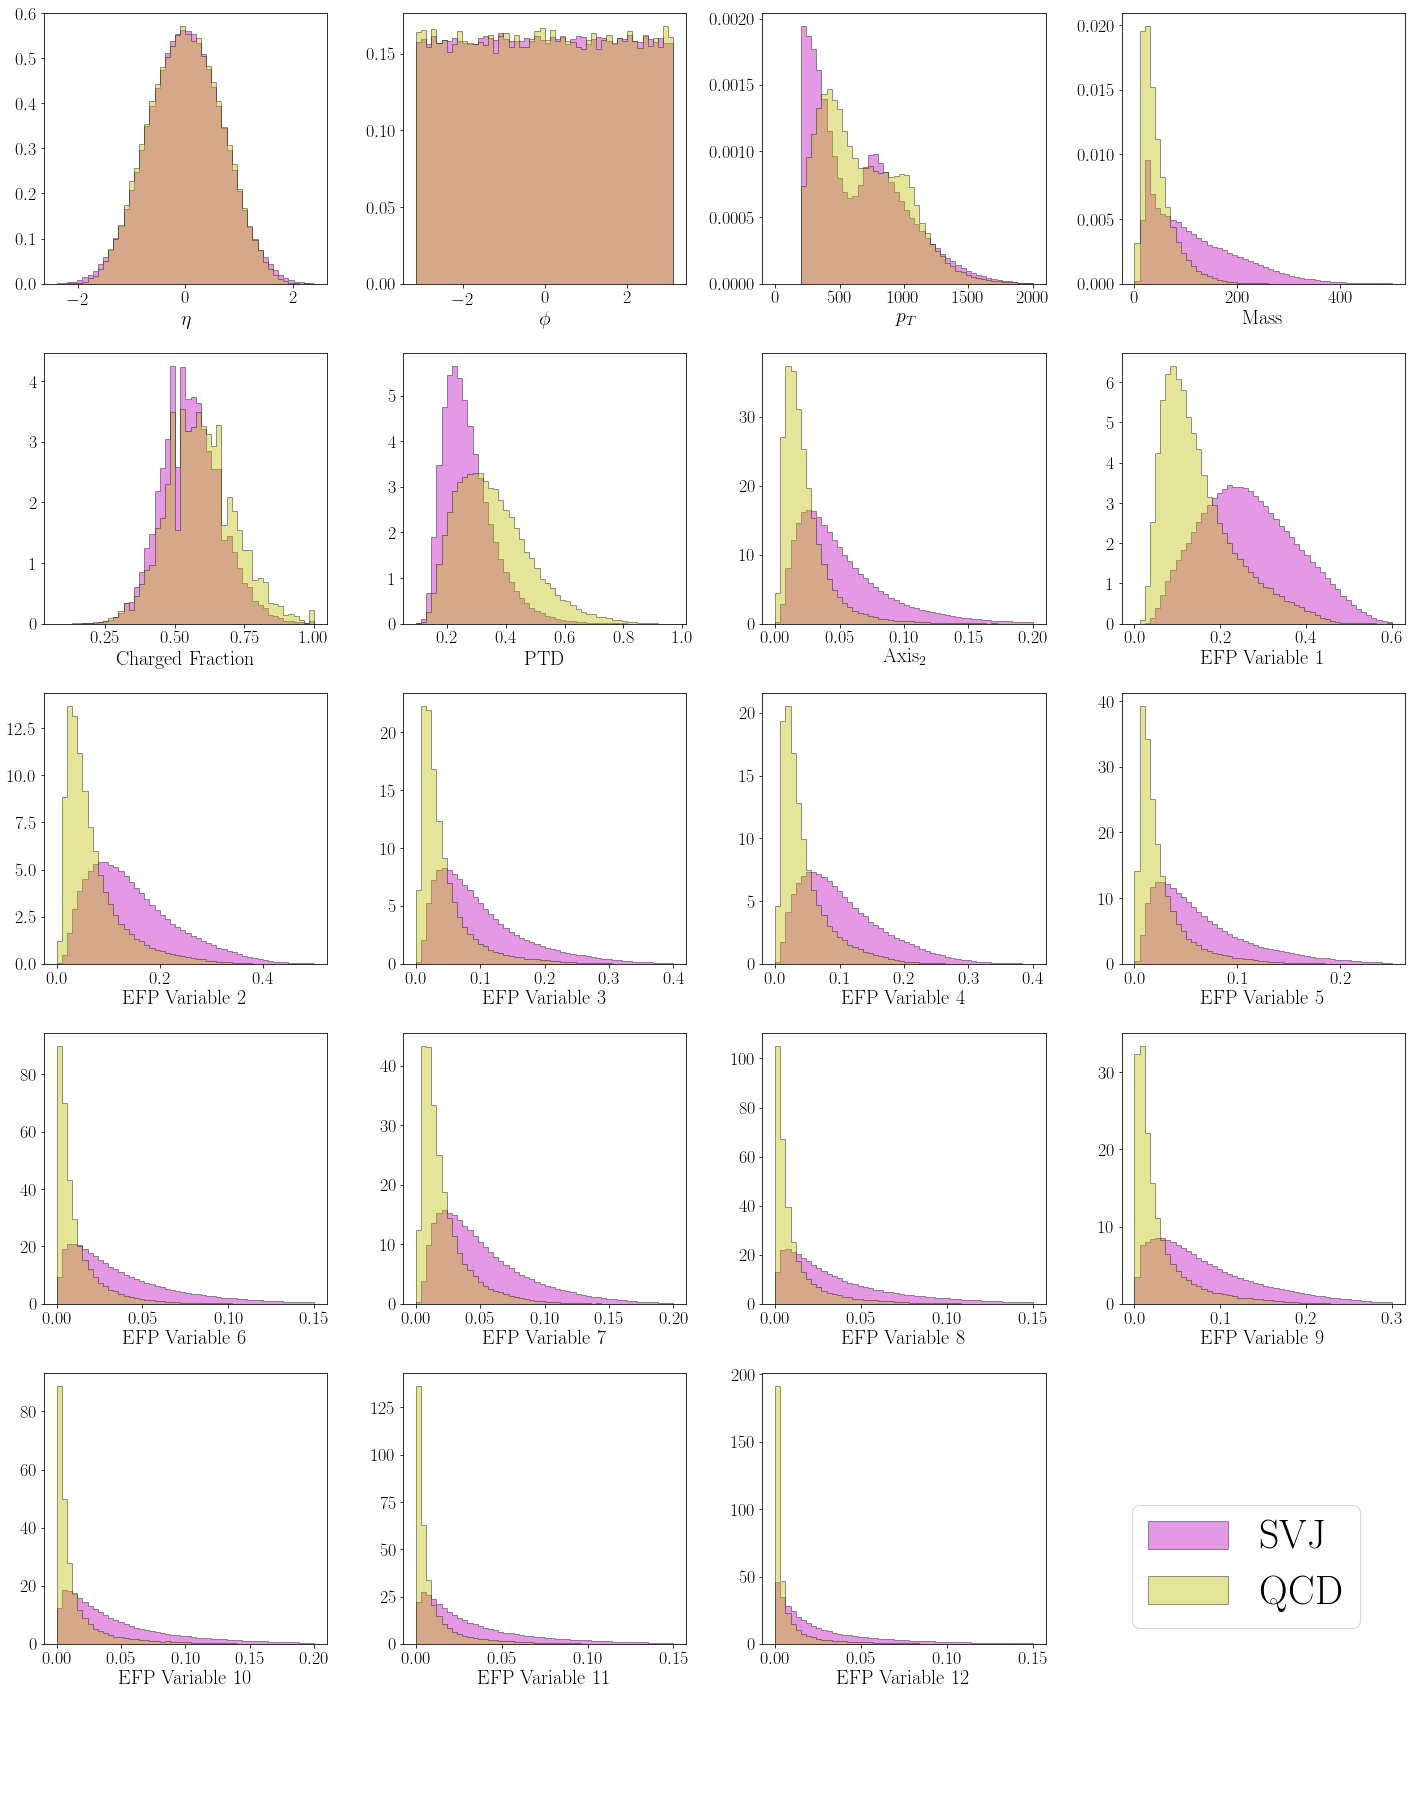

In [108]:
data = converter({'Z': signal, 'qcd': qcd})

bins=50
names="*"
ylabel=None
normed=1
xlog=False
ylog=False
pileup=False
m1 = 20./4.
m2 = 14./3.


fs = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 18})

rows, cols = (6,4)
f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
axs = axs.flatten()
#     f.suptitle("Input Variables", y=1.02, fontsize=30)
ogbins = bins
i = 0
for d,v in data.items():
    var_style = var_styles[d].copy()

    if 'bins' in var_style:
        bins = var_style.pop('bins')
    else:
        bins = ogbins

    if 'range' in var_style:
        rng = var_style.pop('range')
    else:
        rng = map(lambda f: f(map(f, v.values())), [min, max])
    ax = axs[i]

    if 'Variable' in var_style['xlabel']:
        var_style['xlabel'] = "EFP " + var_style['xlabel'] 
#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
    for k in v.keys():

        datum = v[k]

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[k].copy()

#             style['alpha'] = 0.3
        ax.hist(datum, range=rng, bins=nbins, normed=normed, **style)


        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

    i += 1

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(0.8, 0.1), fontsize=40)
for x in axs[i:]:
    f.delaxes(x)


### Post-all

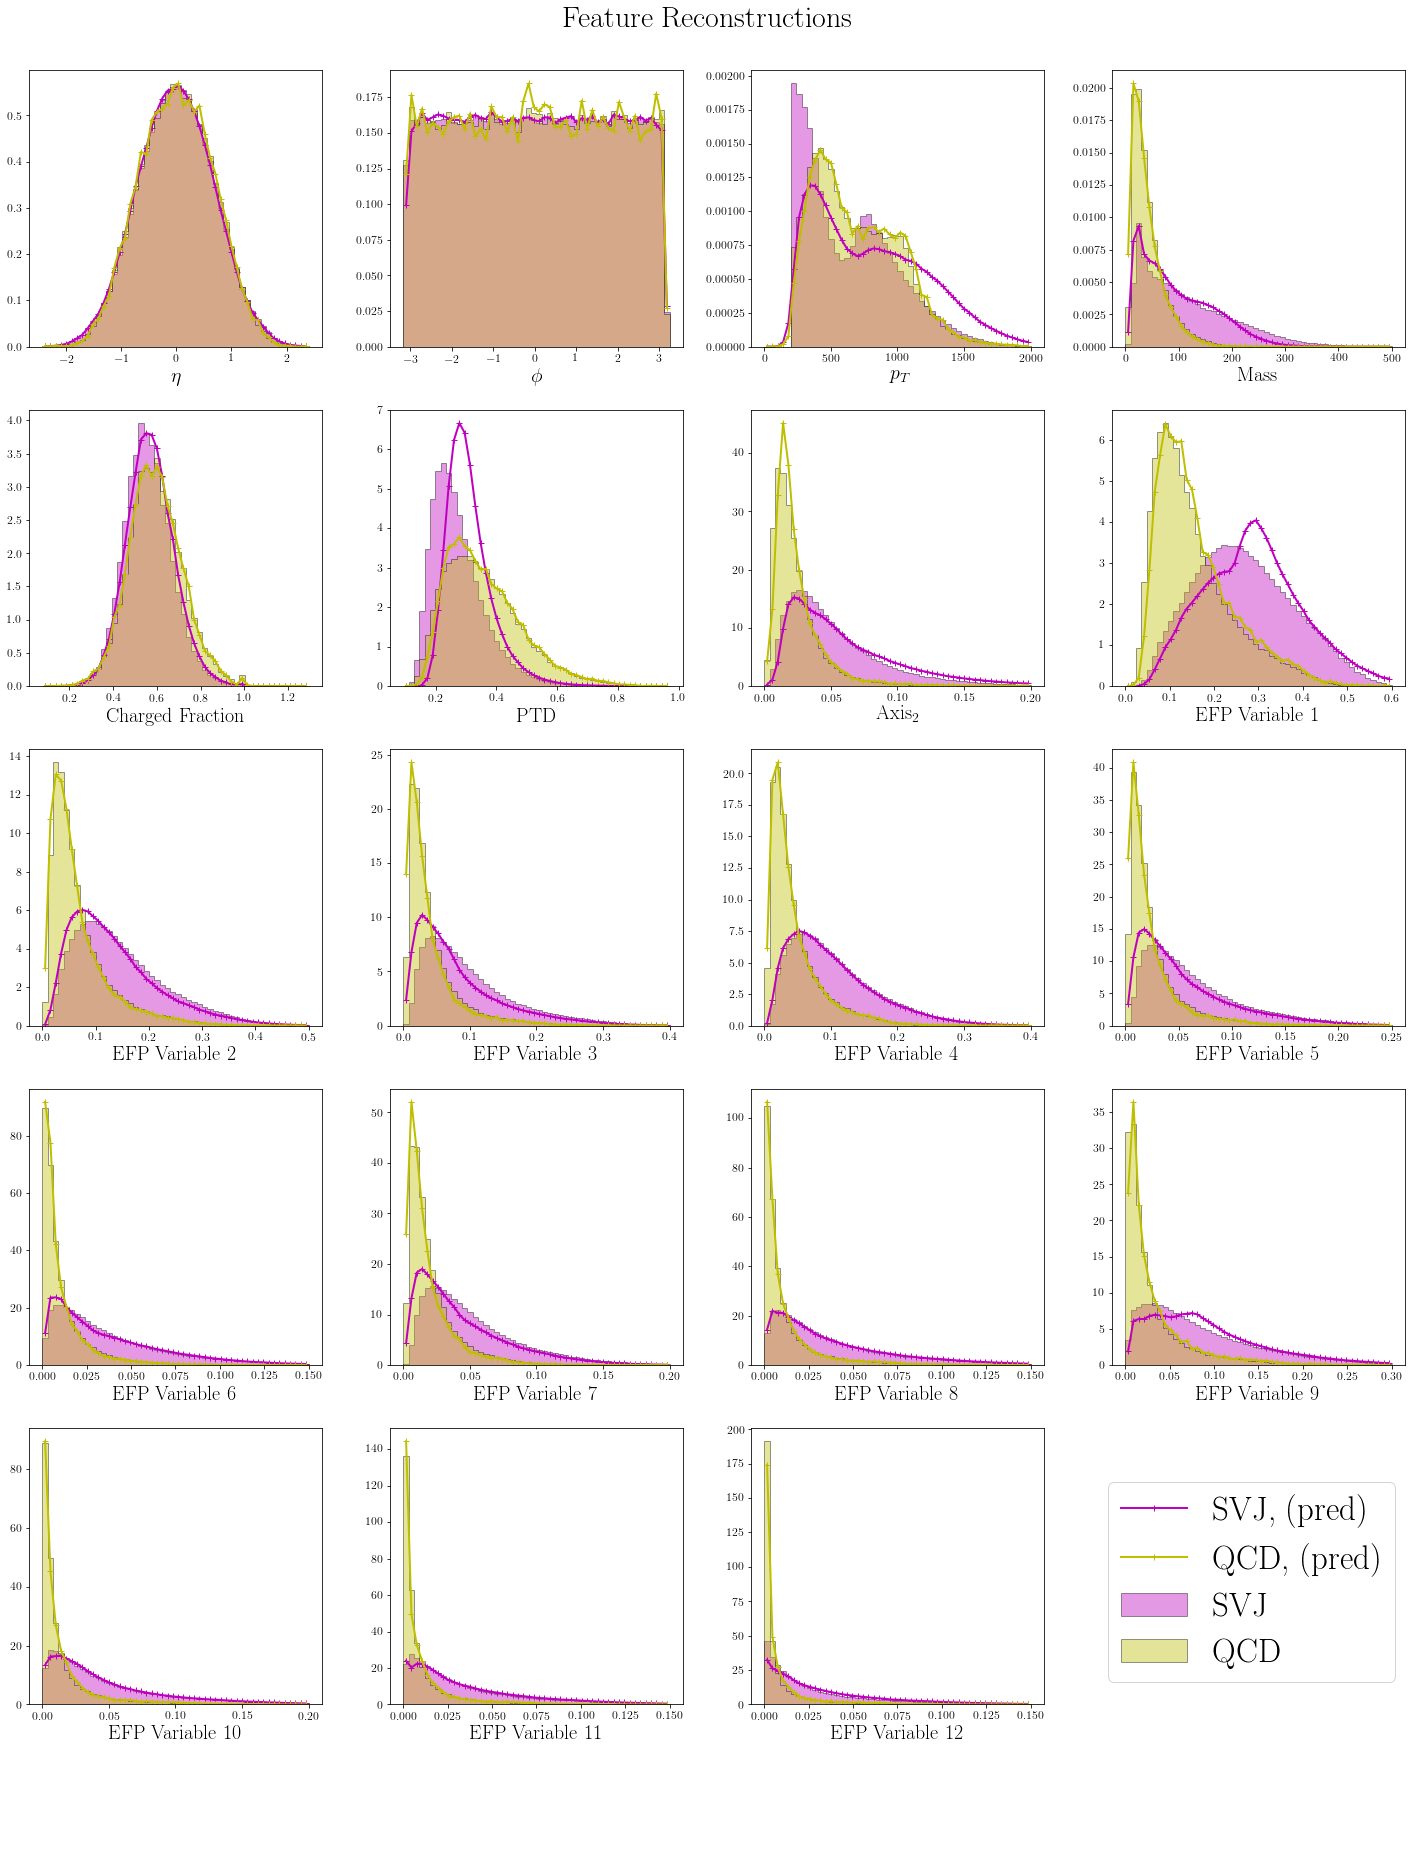

In [109]:
data = converter({
    'Z pred': signal_recon,
    'qcd pred': recon['qcd pred'],
    'Z': signal, 
    'qcd': dists['qcd']
})

bins=50
names="*"
ylabel=None
normed=1
xlog=False
ylog=False
pileup=False
m1 = 20./4.
m2 = 14./3.

recon_kwd = 'pred'
# dists = e.dists_dict.copy()
# dists['qcd'] = e.test
# data = plotdata({recon_kwd : e.recons_dict, 'NONE': dists}, names=names)

fs = 12
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 18})

rows, cols = (6,4)
f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
axs = axs.flatten()
f.suptitle("Feature Reconstructions", y=1.02, fontsize=30)
ogbins = bins
i = 0

for da,v in data.items():
    
    var_style = var_styles[da].copy()
    if 'Variable' in var_style['xlabel']:
        var_style['xlabel'] = "EFP " + var_style['xlabel'] 
    
    if 'bins' in var_style:
        bins = var_style.pop('bins')
    else:
        bins = ogbins

    if 'range' in var_style:
        rng = var_style.pop('range')

    else:
        rng = map(lambda f: f(map(f, v.values())), [min, max])
    ax = axs[i]

#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
    for k in v.keys():

        datum = v[k]
        reconstructed = False
        kp = k 
        if recon_kwd in k:
            reconstructed = True 

            kp = k.replace(recon_kwd, '').strip()

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[kp].copy()

#             style['alpha'] = 0.3
        if reconstructed:
            hist,bins = np.histogram(datum, range=rng, bins=nbins, normed=normed)

            style['color'] = style['facecolor']
            style['linewidth'] = 2
            style['label'] = style['label'] + ', (pred)'
            for var in ['histtype', 'fill', 'facecolor', 'edgecolor', 'hatch', 'alpha']:
                if var in style:
                    style.pop(var)

            ax.plot(bins[:-1] + np.diff(bins)/2., hist, marker='+', alpha=1, **style)
#                 ax.scatter(bins[:-1] + np.diff(bins)/2., hist, marker='+', edgecolor='k', **style)
        else:
            ax.hist(datum, range=rng, bins=nbins, normed=normed, **style)

        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

    i += 1

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.7825,.1), fontsize=33)
for x in axs[i:]:
    f.delaxes(x)

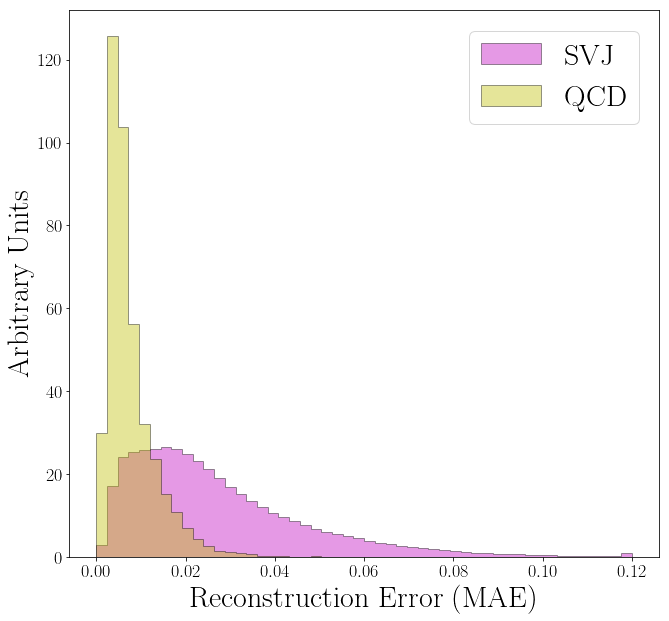

In [110]:
data = converter({'Z': signal_err, 'qcd': errors['qcd']})
data.pop('mse')
bins=50
ylabel=None
normed=1
xlog=False
ylog=False
pileup=True
rng=(0, 0.12)

#     recon_kwd = '(Reconstructed)'
#     data = plotdata(e.errs_dict, names=names, drop=drop)

fs = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 30})

#     rows, cols = (1,1)
f, ax = plt.subplots(1, 1, figsize=(2*m1, 2*m2))

#     f.suptitle("Input Variables", y=1.02, fontsize=30)
ogbins = bins

for d,v in data.items():
    if 'bins' in var_styles[d]:
        bins = var_styles[d].pop('bins')
    else:
        bins = ogbins

    if 'range' in var_styles[d]:
        rng = var_styles[d].pop('range')
    elif rng is None:
        rng = map(lambda f: f(map(f, v.values())), [min, max])


#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
    for k in v.keys():

        datum = v[k]

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[k].copy()

#             style['alpha'] = 0.3
        ax.hist(datum, range=rng,bins=nbins, normed=normed, **style)

        var_style = var_styles[d].copy()
        if 'Variable' in var_style['xlabel']:
            var_style['xlabel'] = "EFP " + var_style['xlabel'] 

        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

ax.set_ylabel('Arbitrary Units')
handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.7,.80), fontsize=30)


In [111]:
lone = agetter.get_aucs(err={v.name: v for v in [errors['qcd'], signal_err]})

from matplotlib import lines as mplines
# errs = e.roc(figsize=10, yscale='log', xscale='log', figname='SVJ vs. QCD error', fontsize=20, show_plot=0)

prop_cycle = plt.rcParams['axes.prop_cycle']
all_colors = prop_cycle.by_key()['color']
all_lines = ['-', '--', '-.', ':', '-']
all_markers = ['x', 'o', 'd', '1', 's', '*']
# all_lines = ["s", "o", "d", "x", "1"]
aucplot = lone.copy()

# masses, nus = map(set, np.asarray([[a.split('_')[1], '{:.2f}'.format(int(a.split('_')[2])/100.)] for a in aucplot.keys()]).T)
# colors = {nu: all_colors[i] for i,nu in enumerate(nus)}
# lines = {nu: '-' for i,nu in enumerate(nus)}
# markers = {mass: all_markers[i] for i,mass in enumerate(masses)}

plt.figure(figsize=(10,10))

used_labels = set()
for a in aucplot:
    for typ in aucplot[a]:
#         mass,nu = a.split('_')[1:]
#         nu = '{:.2f}'.format(int(nu)/100.)
        roc = aucplot[a][typ]['roc']
        auc = aucplot[a][typ]['auc']
        lab = None
#         lab = r'${}$'.format(nu)
#         if lab in used_labels:
#             lab = None
#         used_labels.add(lab)
        plt.plot(roc[0], roc[1], linestyle=lines[nu], c=colors[nu], label=r'$Z^+$ Dark (Avg.): AUC {:.4f}'.format(auc)) 
    #, label=r'${}$, Nu={}'.format(mass, nu))
plt.plot(np.arange(0,1.001,0.001), np.arange(0,1.001,0.001), linestyle='--', c='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Signal Discrimination ROC Curve')
# plt.yscale('log')
# plt.xscale('log')
plt.legend()
# plt.ylim(1e-1, 1)
# plt.xlim(1e-3, 1)

plt.show()

:: TIME: auc grab executed in 0.71 s


NameError: name 'lines' is not defined

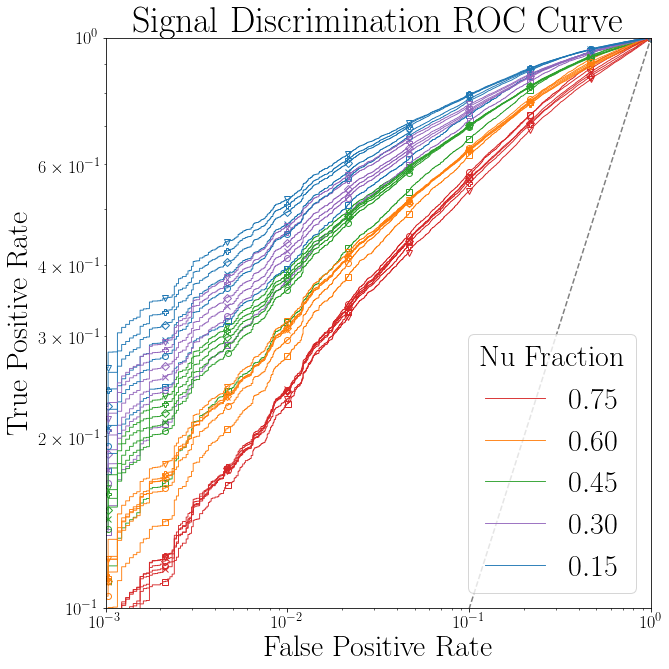

In [136]:
from matplotlib import lines as mplines
# errs = e.roc(figsize=10, yscale='log', xscale='log', figname='SVJ vs. QCD error', fontsize=20, show_plot=0)

prop_cycle = plt.rcParams['axes.prop_cycle']
all_colors = prop_cycle.by_key()['color']
all_lines = ['-', '--', '-.', ':', '-']
all_markers = ['x', 'o', 'v', 'D', 's', 'P']
# all_lines = ["s", "o", "d", "x", "1"]

masses, nus = map(set, np.asarray([[err.split('_')[1], '{:.2f}'.format(int(err.split('_')[2])/100.)] for err in errors.keys() if len(err.split('_')) >= 3]).T)
colors = {nu: all_colors[i] for i,nu in enumerate(nus)}
lines = {nu: '-' for i,nu in enumerate(nus)}
markers = {mass: all_markers[i] for i,mass in enumerate(masses)}

plt.figure(figsize=(10,10))
aucplot = aucs.copy()

dots = np.logspace(-3, -2, len(aucplot))
# index = np.argsort([(k, v['mae']['auc']) for k,v in aucplot.items()],axis=0)[:,1]
index = np.argsort([(k, v['mae']['roc'][1][np.argmin(abs(v['mae']['roc'][0] - 2*1e-3))]) for k,v in aucplot.items()], axis=0)[:,1]
i = 0 

used_labels = set()
used_styles = OrderedDict()
for a in aucplot:
    for typ in aucplot[a]:
        mass,nu = a.split('_')[1:]
        nu = '{:.2f}'.format(int(nu)/100.)
        roc = aucplot[a][typ]['roc']
        auc = aucplot[a][typ]['auc']
        
        lab = r'${}$'.format(nu)
        if lab in used_labels:
            lab = None
        used_labels.add(lab)
        
        
#         nex = dots[index[i]]
        idxs = [np.argmin(abs(roc[0] - x)) for x in np.logspace(-3, 0, 10)]
        nex = 2e-3
#         xplt = np.argmin(abs(roc[0] - nex))
        i += 1 
        
        plt.plot(roc[0], roc[1], linestyle=lines[nu], c=colors[nu], label=lab, linewidth=0.9) 
        used_styles[(nu, mass)] = plt.plot(roc[0][idxs], roc[1][idxs], marker=markers[mass], markeredgecolor=colors[nu], markerfacecolor='None', markersize=6, linestyle='None')
        
    #, label=r'${}$, Nu={}'.format(mass, nu))
plt.plot(np.arange(0,1.001,0.001), np.arange(0,1.001,0.001), linestyle='--', c='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Signal Discrimination ROC Curve')
plt.yscale('log')
plt.xscale('log')
plt.legend(title='Nu Fraction')
plt.ylim(1e-1, 1)
plt.xlim(1e-3, 1)

plt.show()

In [168]:
df = pd.DataFrame({k: v['mae'] for k,v in aucplot.items()}).T['auc'].to_frame()
df['nu'] = [int(x.split('_')[2])/100. for x in df.index.values]
df['mass'] = [int(x.split('_')[1].rstrip('GeV')) for x in df.index.values]
df = df.pivot('mass', 'nu', 'auc')



nu,0.15,0.3,0.45,0.6,0.75
mass,,,,,
1500,0.902034,0.894173,0.877532,0.860241,0.837013
2000,0.91517,0.902749,0.884136,0.859043,0.832561
2500,0.916927,0.901003,0.882299,0.855572,0.822746
3000,0.918679,0.902315,0.882091,0.852213,0.817497
3500,0.920121,0.905257,0.882321,0.849264,0.81174
4000,0.919039,0.906302,0.880837,0.84847,0.802886


[32, 66, 142, 306, 636, 1274, 2400, 4086, 6012, 7680]